In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import sys
import json

import numpy as np
import pandas as pd

import requests

import torch

from PIL import Image
from io import BytesIO
from matplotlib import pyplot

from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModel, CLIPImageProcessor

In [45]:
from utils import get_score_from_embs

# build model

In [2]:
BATCH_SIZE = 64
MAX_LENGTH = 77
MODEL_NAME = 'openai/clip-vit-large-patch14'

In [3]:
preprocessor = CLIPImageProcessor.from_pretrained(MODEL_NAME, local_files_only=True)

clip_model = AutoModel.from_pretrained(MODEL_NAME, local_files_only=True).cuda().eval()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# laion aesthetic

In [4]:
infos = {'URL': ['https://cdn.mumsgrapevine.com.au/site/wp-content/uploads/2020/03/First-Easter-Shoes-360x240.jpg',
  'https://cdn.aws.toolstation.com/images/141020-UK/250/77609-5.jpg',
  'https://i0.wp.com/mystylosophy.com/wp-content/uploads/2017/10/ChristianDior-Dior-DiorExhibit-Paris-HautCouture-GoldenAge-DiorGoldenAge-ArtDecoratifs-PerfumeDior-DiorPerfume-DiorGown-5.jpg?resize=1093%2C729',
  'https://www.goodnet.org/photos/620x0/27271.jpg',
  'https://us.123rf.com/450wm/sivenkovnik/sivenkovnik1808/sivenkovnik180800032/106471031-.jpg?ver=6',
  'https://www.picclickimg.com/d/l400/pict/322429071408_/Genuine-Kids-Oshkosh-girls-fruit-and-flower-skirt.jpg',
  'https://i.pinimg.com/originals/58/be/54/58be542fc4a81775d91bb511f82eeda8.jpg',
  'https://i1.wp.com/toffecamping.me/wp-content/uploads/2016/02/freehand-miami-hostel-photos-exterior.jpeg?w=387&h=253&ssl=1',
  'http://img0106.popscreencdn.com/158526702_2pcs-luxury-doll-clothes-outfit-court-dress-for-.jpg',
  'https://photos.smugmug.com/OP-W-Bloomfield-v-Walled-Lake-Western-football/i-sqr25bK/0/b6b541a8/XL/24AU17%20WLW%20v%20WB%20389-XL.jpg',
  'https://p1.liveauctioneers.com/385/116367/59813930_1_x.jpg?version=1518047604&amp;width=280&amp;format=pjpg&amp;auto=webp&amp;quality=50',
  'https://www.jpost.com//HttpHandlers/ShowImage.ashx?id=391764&w=822&h=537',
  'https://d36tnp772eyphs.cloudfront.net/blogs/1/2019/06/Beautiful-Landscape-of-Grand-Canyon-from-Desert-View-Point-with-the-Colorado-River-visible-during-dusk-900x506.jpg',
  'https://cdn.snsimg.carview.co.jp/minkara/usercar/000/002/957/017/2957017/p4mm.jpg?ct=596692692132',
  'https://i1.wp.com/www.bodycenterbilbao.com/wp-content/uploads/2019/02/shutterstock_113011594-620x3602.jpg?resize=300%2C174&ssl=1',
  'https://thelocalbrand.com/wp-content/uploads/2013/09/Oktoberfest-in-Germany1-300x228.jpg',
  'https://uploads.carandclassic.co.uk/uploads/cars/austin_healey/12069496.jpg',
  'https://www.stoptheboring.com/wp-content/uploads/2017/10/BigMouth-Inc-The-Original-Toilet-Mug-0-1-1.jpg',
  'https://tse4.mm.bing.net/th?id=OIP.XDvNHjjnshLjFrnDH-8kgQEsEs',
  'https://i.pinimg.com/236x/df/f7/ea/dff7ea50cd7bce86bde0042e55c7c4f2.jpg',
  'https://chairish-prod.freetls.fastly.net/image/product/sized/a849c575-81a8-4d76-ad2a-04d0a59c3531/hickory-white-china-cabinet-3284?aspect=fit&width=320&height=320',
  'https://i.pinimg.com/736x/e4/bc/a9/e4bca97b76cf55c0195999c1b03b92a7--ex-voto-milagro.jpg',
  'https://lifeovercs.com/wp-content/uploads/2016/03/easter-egg-hunt2-700x464.jpg',
  'https://i2.wp.com/runningonrealfood.com/wp-content/uploads/2021/03/Healthy-Vegan-Chocolate-Banana-Muffins-Recipe-7-700x1050.jpg',
  'https://elizabethandjane.ca/wp-content/uploads/2019/02/Ottawa-dows-lake-14.jpg',
  'https://www.1st-art-gallery.com/frame-preview/27856027.jpg?sku=Unframed&amp;w=24&amp;h=20&amp;thumb=0&amp;huge=0',
  'https://sugargeekshow.com/wp-content/uploads/2020/11/lemon_shortbread_cookies-13-of-16.jpg',
  'https://www.picclickimg.com/d/l400/pict/113373763354_/Vintage-1986-AVON-Musical-Figurine-We-wish.jpg',
  'https://thumbs.dreamstime.com/b/amazing-view-zermatt-village-switzerland-famous-mountain-matterhorn-background-snow-top-beautiful-swiss-nature-alps-153230814.jpg',
  'https://t1.ftcdn.net/jpg/00/57/36/02/240_F_57360264_MRBt4bmlmoaOw6pd6GMPVMdPCGJ93HeF.jpg',
  'https://www.joyofkosher.com/.image/ar_8:10%2Cc_fill%2Ccs_srgb%2Cg_faces:center%2Cq_80%2Cw_620/MTMxNzYxNjUzOTA0NjMzODI2/strawberry-and-watermelon-smoothies-and-popsicles.jpg',
  'https://p1.liveauctioneers.com/1325/132379/67249133_3_x.jpg?version=1543773410&amp;width=54&amp;format=pjpg&amp;auto=webp&amp;quality=25',
  'https://www.jetsetter.com/uploads/sites/7/2018/04/bedroom-boutique-desert-inn.jpeg',
  'https://i.etsystatic.com/20135037/r/il/34cfb1/2165843230/il_340x270.2165843230_n8ok.jpg',
  'https://i.pinimg.com/236x/f1/dc/a7/f1dca70ae1dda0aea1bfc54136d2dab2--vintage-cocktail-dress-vintage-cocktails.jpg',
  'https://images.stockfreeimages.com/1975/sfi226w/19758677.jpg',
  'https://ir.redata.com/ir/do.php?src=http://www.redata.com/100042/mls/stillsminmmls/463426at.jpg?1618351007238&w=340',
  'https://www.gannett-cdn.com/presto/2018/11/07/PPHX/828c8824-f54b-4788-bd2b-9e2c48afb792-if06518r3.jpg?width=540&amp;height=405&amp;fit=bounds&amp;auto=webp',
  'https://us.123rf.com/450wm/lembergvector/lembergvector1912/lembergvector191200010/135337867-street-food-market-flat-color-vector-illustration-outdoor-marketplace-in-megapolis-vendors-and-custo.jpg?ver=6',
  'https://www.wolverton-mountain.com/articles/images/apple_doesnt_fall_far/2.jpg',
  'https://cdn.iconscout.com/icon/premium/png-128-thumb/cop-1922937-1630084.png',
  'http://car-from-uk.com/ebay/carphotos/big/ebay49671.jpg',
  'https://t0.gstatic.com/images?q=tbn:ANd9GcSVQOjeIbY7NbyywMki5Qv_r8d3yNeVozVbqJLBe35x31rGP04T',
  'https://9qjzgzbyth-flywheel.netdna-ssl.com/wp-content/uploads/2018/06/snowmobile-tour-330x220.jpg',
  'https://i0.wp.com/cdn.dealeraccelerate.com/rkm/1/3055/202154/1920x1440/w/1970-chevrolet-chevelle-super-sport?w=2000',
  'https://img.monocle.com/gallery/a_8434054-53a16a5c3980b.jpg?w=533&amp;h=400&amp;&amp;g=center&amp;q=60',
  'https://insitu-app.co.uk/wp-content/uploads/2015/12/canvas-9.jpg',
  'https://pennsylvaniastatehealth.com/wp-content/uploads/sites/99/2020/09/4.jpg',
  'https://redballoon.com.au/dw/image/v2/BCRD_PRD/on/demandware.static/-/Sites-rb-au-catalog/default/images/products/MEW007-M/asp7dpzcl9msbcmbplfz.jpg?sw=540&sh=302&q=70',
  'https://cdn.shopify.com/s/files/1/0255/2515/products/505430ca6149f3fbd56613297df67da4_300x300.jpg?v=1587106552',
  'https://render.fineartamerica.com/images/rendered/medium/greeting-card/images/artworkimages/medium/1/hummingbird-perched-on-an-orchid-plant-martin-johnson-heade-.jpg',
  'https://www.ramascreen.com/wp-content/uploads/Trainspotting.png',
  'http://i.pinimg.com/236x/40/d3/0b/40d30b62d2d2f088f68469937a0b57ee.jpg',
  'https://bbyv231eix01sh2v620d8ptq-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/who_are_the_archangels-560x600.jpg',
  'http://www.tlaquepaque-centro.com/images/image_bank/IMG_4218_folkloric_dance_fixt_net.jpg',
  'https://cinemaholics.ru/content/images/2019/02/leaving-neverland-1.jpg',
  'https://i.pinimg.com/236x/ee/7c/9a/ee7c9a837444155e31dfa4c60f03cb98--western-furniture-log-furniture.jpg',
  'https://render.fineartamerica.com/images/rendered/medium/poster/images-medium/herns-mill-covered-bridge-harold-rau.jpg',
  'https://talksport.com/wp-content/uploads/sites/5/2021/08/2bca362c-a5b8-40dc-9625-00ec45e31397.jpg?strip=all&w=960&quality=100',
  'https://www.kilroyworld.nl/media/10152/piha-beach-auckland-new-zealand.jpg?mode=crop&quality=70',
  'https://images1.sw-cdn.net/product/picture/710x528_2228635_1902959_1459328248.jpg',
  'https://www.christies.com/img/LotImages/2007/AMS/2007_AMS_02765_0057_000().jpg?mode=max&amp;Width=200',
  'https://3dlancer.net/upload/galleries/801/3801/bedroom-in-a-country-house-by-the-river-65129-xxl.jpg',
  'https://us.123rf.com/450wm/OlgaDrozdova/OlgaDrozdova1309/OlgaDrozdova130900018/22176210-black-seamless-floral-pattern-with-vivid-flowers-and-colorful-transparent-butterflies.jpg',
  'https://i.pinimg.com/originals/e3/8d/8f/e38d8f597d3b2a4b61729717b9840f53.jpg',
  'https://parkcity.org/home/showpublishedimage/3877/636717456062930000',
  'http://deliciouslyyum.com/wp-content/uploads/2014/08/chocolate-chunk-cookie-butter-bars-6.jpg',
  'https://thumbs.dreamstime.com/b/winter-panorama-landscape-forest-trees-covered-snow-sunrise-winterly-morning-new-day-purple-winter-landscape-102655259.jpg',
  'https://i.pinimg.com/736x/56/24/7a/56247aba8b75d4627168dbe8d1df4fcb.jpg',
  'https://d1s2pua8v98dyj.cloudfront.net/mk/images/p368226_2x.jpg?w=436',
  'https://dygtyjqp7pi0m.cloudfront.net/i/39201/33669039_1m.jpg?v=8D70875CDDDB730',
  'https://www.royalwolf.co.nz/uploads/images/products/UsedContainer_Category.jpg',
  'https://i0.wp.com/stylefemale.com/wp-content/uploads/2018/09/50-best-pink-wedding-clothes-ideas-42.jpg?w=283&h=376&ssl=1',
  'https://auto-database.com/image/pictures-of-opel-zafira-a-1999-112166.jpg',
  'https://i0.wp.com/www.pandotrip.com/wp-content/uploads/2018/04/Interlaken-town-and-Aare-river-from-the-view-point-of-Harder-Kulm-Switzerland.jpg?resize=740%2C493&ssl=1',
  'https://www.bestformykitchen.com/images/25100/15-French-Hydrangea-Flowers-Melamine-Serving-Tray-32.jpg',
  'https://t1.ftcdn.net/jpg/02/34/46/38/240_F_234463822_KObP2qGSecXOUh2mlw0KyqIXHSoUWK7h.jpg',
  'https://i.ebayimg.com/images/g/KFIAAOSw86JaXOJy/s-l500.jpg',
  'https://prettydiyhome.com/wp-content/uploads/2021/06/Rocky-Road-Smores-Bark-a-Pumpkin-and-a-Princess-700-683x1024.jpg',
  'https://render.fineartamerica.com/images/rendered/default/greeting-card/images-medium-5/poster-advertising-caco-van-houten-privat-livemont.jpg?&targetx=0&targety=-307&imagewidth=500&imageheight=1315&modelwidth=500&modelheight=700&backgroundcolor=DAC9AA&orientation=1',
  'https://rieger-tuning.es/wp-content/uploads/2020/01/00055226_5-600x313.jpg',
  'https://i.pinimg.com/236x/07/ae/4c/07ae4c3944b670772daa6e2e236d22de.jpg',
  'https://www.casabouquet.com/wp-content/uploads/2017/04/orange-chocolate-chip-16.jpg',
  'https://frommybowl.com/wp-content/uploads/2020/03/Vegan_Strawberry_Shortcakes_GlutenFree_FromMyBowl_SugarFree-10-scaled.jpg',
  'https://ih0.redbubble.net/image.555016608.2521/raf,360x360,075,t,fafafa:ca443f4786.jpg',
  'https://i0.wp.com/ritacor.files.wordpress.com/2016/07/self-portrait-with-monkey-and-parrot.jpg?w=370&',
  'https://thumbs2.ebaystatic.com/d/l225/m/mXR8HQ3gZN9zybpJWKm7p0g.jpg',
  'https://images.globalauctionguide.com/769021/320x240/769021_90_c45a2d97c628341011686e4545c1782e.jpg',
  'https://static.barcelo.com/content/dam/bhg/master/es/hoteles/spain/andalucia/sevilla/imagenes-sevilla/iStock-534917469.jpg.bhgimg.jpg/1604514693284.jpg',
  'https://i.ebayimg.com/00/s/ODAwWDYwMA==/z/UPQAAOSwdsFeq-Uu/$_118.PNG',
  'https://www.mikereyfman.com/wp-content/gallery/lake-powell-glen-canyon-colorado-san-juan-river-utah-arizona-usa/thumbs/thumbs_012-LP3_O3X4981.jpg',
  'https://www.okchicas.com/wp-content/uploads/2020/10/Aretes-en-forma-de-postres-3.jpg',
  'http://viemagazine.com/wp-content/uploads/2018/09/vie-magazine-sendwell-hero-min.jpg',
  'https://lid.zoocdn.com/354/255/fc91a54394578a3e60a1c1e35fe550303500ffba.jpg',
  'https://www.baltimoreschild.com/wp-content/uploads/2020/07/FairyGarden-310x165.jpg',
  'http://i.ytimg.com/vi/A9MgeWQvPu8/0.jpg',
  'https://crochetdreamz.com/wp-content/uploads/2018/07/2carpet-059-copy-2-4-220x220_c.jpg',
  'https://www.estylecdn.com/manufcols/marysbridal/current/zoomalt/4Q371-1.jpg',
  'http://t0.gstatic.com/images?q=tbn:ANd9GcT2eBMR4mG2ZaebrBMS_cf17_V12iuHuctdZtmve5LKEqK1nhry',
  'https://images.custommade.com/hEtRIgU4LJudMKV82JzPjO2Wj7Y=/fit-in/510x382/custommade-photosets/81393/81393.216214.jpg'],
 'aesthetic': [7.172502517700195,
  7.551183223724365,
  7.591557025909424,
  7.301273345947266,
  7.366945266723633,
  7.25872802734375,
  7.846107006072998,
  7.444241046905518,
  8.693609237670898,
  7.310762405395508,
  7.313165664672852,
  7.356822967529297,
  7.1000800132751465,
  7.744609355926514,
  7.250083923339844,
  7.058066368103027,
  7.170432090759277,
  7.129290580749512,
  7.770288944244385,
  7.353501319885254,
  7.031122207641602,
  7.452410697937012,
  7.258460521697998,
  7.380912780761719,
  7.315114974975586,
  7.175784587860107,
  7.417852878570557,
  7.428484916687012,
  7.052938461303711,
  7.239180088043213,
  7.764685153961182,
  7.01607608795166,
  7.205810070037842,
  7.004315376281738,
  7.178605079650879,
  7.785758972167969,
  7.769811153411865,
  7.801805019378662,
  7.839773654937744,
  7.182727813720703,
  7.1983771324157715,
  7.612484455108643,
  7.85885763168335,
  7.421217441558838,
  8.203147888183594,
  7.089407920837402,
  7.655054569244385,
  7.161921501159668,
  7.556063175201416,
  7.531184196472168,
  7.3606276512146,
  7.462562561035156,
  7.9463934898376465,
  7.310300350189209,
  7.150605201721191,
  7.310141563415527,
  7.013078689575195,
  7.998131275177002,
  7.013938903808594,
  7.156905651092529,
  7.274003028869629,
  7.754013538360596,
  7.134812355041504,
  7.6007466316223145,
  7.012784004211426,
  7.73198938369751,
  7.115525722503662,
  7.755051136016846,
  7.201910495758057,
  7.41689395904541,
  7.098658084869385,
  7.005938529968262,
  7.655755519866943,
  7.811648845672607,
  7.1286702156066895,
  7.272104263305664,
  7.206401824951172,
  7.161147117614746,
  7.017979145050049,
  7.734507083892822,
  7.720720291137695,
  7.329319000244141,
  7.672746181488037,
  7.8711161613464355,
  7.9984259605407715,
  7.2667694091796875,
  7.137083053588867,
  7.076663017272949,
  7.2775444984436035,
  7.068422317504883,
  7.529209136962891,
  7.268115997314453,
  7.737618446350098,
  7.971368312835693,
  7.379256248474121,
  7.057469844818115,
  7.4130859375,
  7.316041469573975,
  7.42244291305542,
  7.312711715698242]}

In [5]:
proxies = {
    'http': 'http://10.68.98.153:7890',
    'https': 'http://10.68.98.153:7890'
}

In [17]:
images = list()
scores = list()
image_features = list()
for url, score in tqdm(zip(infos['URL'], infos['aesthetic']), leave=False):
    
    try:
        response = requests.get(url, proxies=proxies)
        image = Image.open(BytesIO(response.content))
    except:
        continue
    
    images.append(image)
    
    image = preprocessor(images=image, return_tensors="pt")
    
    image_feature = clip_model.get_image_features(pixel_values=image['pixel_values'].to(clip_model.device))
    image_features.append(image_feature.detach().cpu().numpy())
    scores.append(score)
    
image_features = np.concatenate(image_features, axis=0)

# aesthetic-predictor

In [ ]:
# https://github.com/LAION-AI/aesthetic-predictor

In [25]:
model = torch.nn.Linear(768, 1)

In [26]:
model.load_state_dict(torch.load('./weight/014/sa_0_4_vit_l_14_linear.pth'))

<All keys matched successfully>

In [27]:
model = model.cuda()
model.eval();

In [30]:
with torch.no_grad():
    x = torch.tensor(image_features).cuda()
    pred = model(x / x.norm(dim=-1, keepdim=True))

# improved-aesthetic-predictor

In [7]:
# https://github.com/christophschuhmann/improved-aesthetic-predictor

In [8]:
model = torch.nn.Sequential()
model.add_module('layers', torch.nn.Sequential(
    torch.nn.Linear(768, 1024),
    #nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 128),
    #nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 64),
    #nn.ReLU(),
    torch.nn.Dropout(0.1),

    torch.nn.Linear(64, 16),
    #nn.ReLU(),

    torch.nn.Linear(16, 1)
))

In [9]:
model.load_state_dict(torch.load('./weight/014/sac+logos+ava1-l14-linearMSE.pth'))

<All keys matched successfully>

In [10]:
model = model.cuda()
model.eval();

In [12]:
def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

In [18]:
with torch.no_grad():
    pred = model(torch.tensor(normalized(image_features)).cuda())

# NSFW-Detector

In [ ]:
# https://github.com/LAION-AI/CLIP-based-NSFW-Detector

In [ ]:
# from tensorflow.keras.models import load_model
# model_dir = './weight/014/clip_autokeras_binary_nsfw/'
# model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
# state_dict = dict()
# state_dict['norm.mean'] = model.layers[2].weights[0].numpy()
# state_dict['norm.variance'] = model.layers[2].weights[1].numpy()
# state_dict['linear_1.weight'] = model.layers[3].weights[0].numpy().T
# state_dict['linear_1.bias'] = model.layers[3].weights[1].numpy()
# state_dict['linear_2.weight'] = model.layers[5].weights[0].numpy().T
# state_dict['linear_2.bias'] = model.layers[5].weights[1].numpy()
# state_dict['linear_3.weight'] = model.layers[7].weights[0].numpy().T
# state_dict['linear_3.bias'] = model.layers[7].weights[1].numpy()
# state_dict['linear_4.weight'] = model.layers[9].weights[0].numpy().T
# state_dict['linear_4.bias'] = model.layers[9].weights[1].numpy()

# np.savez('./weight/014/lip_autokeras_binary_nsfw.npz', **state_dict)

In [34]:
class Normalization(torch.nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.register_buffer('mean', torch.zeros(shape))
        self.register_buffer('variance', torch.ones(shape))

    def forward(self, x):
        return (x - self.mean) / self.variance.sqrt()

class NSFWModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = Normalization([768])
        self.linear_1 = torch.nn.Linear(768, 64)
        self.linear_2 = torch.nn.Linear(64, 512)
        self.linear_3 = torch.nn.Linear(512, 256)
        self.linear_4 = torch.nn.Linear(256, 1)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.norm(x)
        x = self.act(self.linear_1(x))
        x = self.act(self.linear_2(x))
        x = self.act(self.linear_3(x))
        x = self.linear_4(x)
        return x

In [48]:
model = NSFWModel().cuda()
npz = np.load('./weight/014/clip_autokeras_binary_nsfw.npz')
model.load_state_dict({k: torch.tensor(v) for k, v in npz.items()})

<All keys matched successfully>

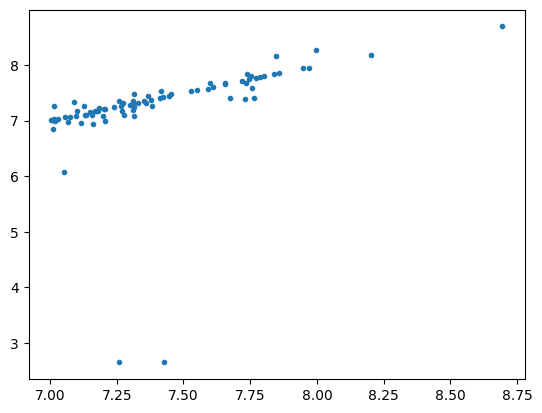

In [33]:
pyplot.plot(scores, pred[..., 0].detach().cpu().numpy(), '.')

In [56]:
npz = np.load('../dataset/scrap/civitai-2023-11-14.npz', allow_pickle=True)

id_to_index = {j:i for i, j in enumerate(npz['id'])}

In [40]:
CLIP_DIR = '../dataset/civitai-stable-diffusion-337k/clip/'

In [61]:
ids = list()
vectors = list()
for fname in tqdm(os.listdir(CLIP_DIR), leave=False):
    
    fid = int(os.path.splitext(fname)[0])
    if fid not in id_to_index:
        continue
    
    vectors.append(np.load(os.path.join(CLIP_DIR, fname)))
    ids.append(fid)

vectors = np.concatenate(vectors, axis=0)
indices = list(map(id_to_index.get, ids))

  0%|          | 0/80418 [00:00<?, ?it/s]

In [62]:
scores = get_score_from_embs(vectors, model, BATCH_SIZE)

  0%|          | 0/1236 [00:00<?, ?it/s]

In [63]:
nsfw = npz['nsfw'][indices]

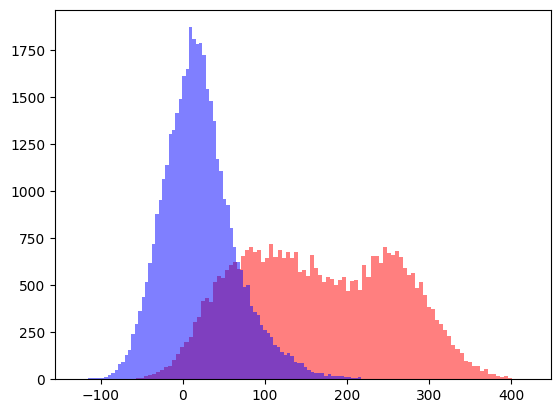

In [67]:
_ = pyplot.hist(scores[nsfw], bins=100, color='red', alpha=0.5)
_ = pyplot.hist(scores[~nsfw], bins=100, color='blue', alpha=0.5)